In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import xarray as xr
from sqlalchemy.sql import text

plt.style.use("ggplot")

# 1000 Lakes deposition series (NILU BLR grid)

See e-mail from Øyvind received 08.06.2023 at 14.57.

## 1. Runoff normal from NVE (1991-2020)

This has not changed since the preliminary version I processed in November 2022 (see `check_prelim_final_nve_runoff_1991-2020.ipynb` for details). The processing in `1000_lakes_mean_runoff.ipynb` is therefore still valid, as is the dataset `1000_lakes_catchment_mean_runoff_1991-2020.csv`.

## 2. NILU deposition data

From Øyvind:

> - 5-års midler 1978-2021 på BLR-rutenett (0.25°×0.125°): 
> - total non-sea salt sulfur dep (mg S/m2y)
> - total oxidised nitrogen dep (mg N/m2y)
> - total reduced nitrogen dep (mg N/m2y)
> - Periodene 1983-87 og 1988-92 mangler oppsplitting av tot-N i Oks-N/Red-N på BLR-rutenett. Oks-N/Red-N fra 50km x 50km datasettet overføres derfor til BLR datasettet for disse periodene

**Note:** After some exploration, the EMEP 50 x 50 km dataset is quite different to the NILU data. Instead of using the EMEP values, Øyvind has therefore suggested the following:

 * For 1983-87, first perform regression of Oks vs. total N for 1978-82 to obtain the typical proportion of Oks:Red, then use this factor with the totals for 1983-87
 * For 1988-92, do the same, but use regression based on data for 1992-96

In [2]:
# Connect to PostGIS
cl_eng = nivapy.da.connect_postgis(database="critical_loads")
eng = nivapy.da.connect_postgis()

Connection successful.
Connection successful.


In [3]:
# Series to use
series_dict = {
    1: ("blr", 1978, 1982),
    29: ("blr", 1983, 1987),  # Assumes 50:50 split between Oks and Red N
    30: ("blr", 1988, 1992),  # Assumes 50:50 split between Oks and Red N
    2: ("blr", 1992, 1996),
    3: ("blr", 1997, 2001),
    4: ("blr", 2002, 2006),
    25: ("blr", 2007, 2011),
    26: ("blr", 2012, 2016),
    66: ("blr", 2017, 2021),
}

In [4]:
# Get outflows and catchments for 1000 lakes
stn_gdf, cat_gdf = nivapy.da.select_jhub_project_catchments([4], eng)

# Reproject to UTM Zone 33N for accurate distances
stn_gdf = stn_gdf.to_crs("epsg:25833")

# Loop over series
df_list = []
for series_id, series_data in series_dict.items():
    grid, st_yr, end_yr = series_data

    # Get spatial grid
    sql = text(f"SELECT * FROM deposition.dep_grid_{grid}")
    grid_gdf = gpd.read_postgis(sql, cl_eng).to_crs("epsg:25833")

    # Read dep data
    sql = (
        "SELECT a.series_id, "
        "  a.cell_id, "
        "  b.name, "
        "  a.value, "
        "  b.unit "
        f"FROM deposition.dep_values_{grid}_grid a, "
        "  deposition.dep_param_defs b "
        "WHERE a.series_id = :series_id "
        "AND a.param_id IN (1, 2, 4) "
        "AND a.param_id = b.param_id"
    )
    if grid == "emep":
        sql += " AND veg_class_id = 1"
    sql = text(sql)
    dep_df = pd.read_sql(sql, cl_eng, params={"series_id": series_id})
    dep_df["par_unit"] = dep_df["name"] + "_" + dep_df["unit"]
    del dep_df["name"], dep_df["unit"], dep_df["series_id"]
    dep_df.set_index(["cell_id", "par_unit"], inplace=True)
    dep_df = dep_df.unstack("par_unit")
    dep_df.columns = dep_df.columns.get_level_values(1)
    dep_df.reset_index(inplace=True)
    dep_df.rename(
        {
            "N(oks)_mg N/m2/year": "n_oks_mgpm2pyr",
            "N(red)_mg N/m2/year": "n_red_mgpm2pyr",
            "S*_mg S/m2/year": "s*_mgpm2pyr",
        },
        inplace=True,
        axis="columns",
    )
    dep_df.index.name = ""

    # Join to BLR grid
    dep_gdf = grid_gdf.merge(dep_df, how="inner", on="cell_id").copy()

    # Spatial join. Using 'within' fails for 7 stations that are slightly outside the
    # BLR grid. Using 'sjoin_nearest' patches with the closest values
    # join_gdf = stn_gdf.sjoin(dep_gdf, how="left", predicate="within")
    join_gdf = stn_gdf.sjoin_nearest(dep_gdf, how="left")

    # Tidy
    join_gdf["period"] = f"{st_yr}-{end_yr}"
    join_gdf["grid"] = grid
    join_gdf["n_tot_mgpm2pyr"] = join_gdf["n_oks_mgpm2pyr"] + join_gdf["n_red_mgpm2pyr"]
    cols = [
        "station_id",
        "station_code",
        "station_name",
        "aquamonitor_id",
        "longitude",
        "latitude",
        # "grid",
        # "cell_id",
        "period",
        "n_oks_mgpm2pyr",
        "n_red_mgpm2pyr",
        "n_tot_mgpm2pyr",
        "s*_mgpm2pyr",
    ]
    join_df = join_gdf[cols]
    df_list.append(join_df)

df = pd.concat(df_list, axis="rows")
df.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,period,n_oks_mgpm2pyr,n_red_mgpm2pyr,n_tot_mgpm2pyr,s*_mgpm2pyr
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,1978-1982,414.23,389.37,803.60,782.41
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,1978-1982,576.11,502.89,1079.00,1085.72
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,1978-1982,469.13,412.21,881.34,910.22
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,1978-1982,312.24,281.38,593.62,616.06
4,263,425-2-2,Kottern,26074,12.511994,60.587319,1978-1982,394.63,355.97,750.60,781.49


This dataframe contains all the required data, but it currently assumes a 50:50 split between Oks and Red N for 1983-87 and 1988-92. Øyvind would like to improve these estimated using linear regression for the period before and after the ones with missing values.

In [5]:
# Map periods with data to periods to be patched
period_dict = {"1978-1982": "1983-1987", "1992-1996": "1988-1992"}
for ref_per, update_per in period_dict.items():
    # Perform regression
    print(
        "\n########################################################################################"
    )
    reg_df = df.query("period == @ref_per").copy()
    res = smf.ols(formula="n_oks_mgpm2pyr ~ n_tot_mgpm2pyr - 1", data=reg_df).fit()
    slope = res.params[0]
    print(f"{ref_per}: Slope={slope:.2f}    R2={res.rsquared:.3f}.")
    print(res.summary())

    # Update values
    df["n_oks_mgpm2pyr"] = np.where(
        df["period"] == update_per, slope * df["n_tot_mgpm2pyr"], df["n_oks_mgpm2pyr"]
    )

# Recalculate reduced fraction
df["n_red_mgpm2pyr"] = df["n_tot_mgpm2pyr"] - df["n_oks_mgpm2pyr"]

# Save
csv_path = r"../data/1000_lakes_nilu_dep_1978-2021.csv"
df.to_csv(csv_path, index=False)

df.head()


########################################################################################
1978-1982: Slope=0.49    R2=0.995.
                                 OLS Regression Results                                
Dep. Variable:         n_oks_mgpm2pyr   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          2.117e+05
Date:                Wed, 14 Jun 2023   Prob (F-statistic):                        0.00
Time:                        12:59:17   Log-Likelihood:                         -4680.4
No. Observations:                1001   AIC:                                      9363.
Df Residuals:                    1000   BIC:                                      9368.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                              

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,period,n_oks_mgpm2pyr,n_red_mgpm2pyr,n_tot_mgpm2pyr,s*_mgpm2pyr
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,1978-1982,414.23,389.37,803.60,782.41
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,1978-1982,576.11,502.89,1079.00,1085.72
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,1978-1982,469.13,412.21,881.34,910.22
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,1978-1982,312.24,281.38,593.62,616.06
4,263,425-2-2,Kottern,26074,12.511994,60.587319,1978-1982,394.63,355.97,750.60,781.49


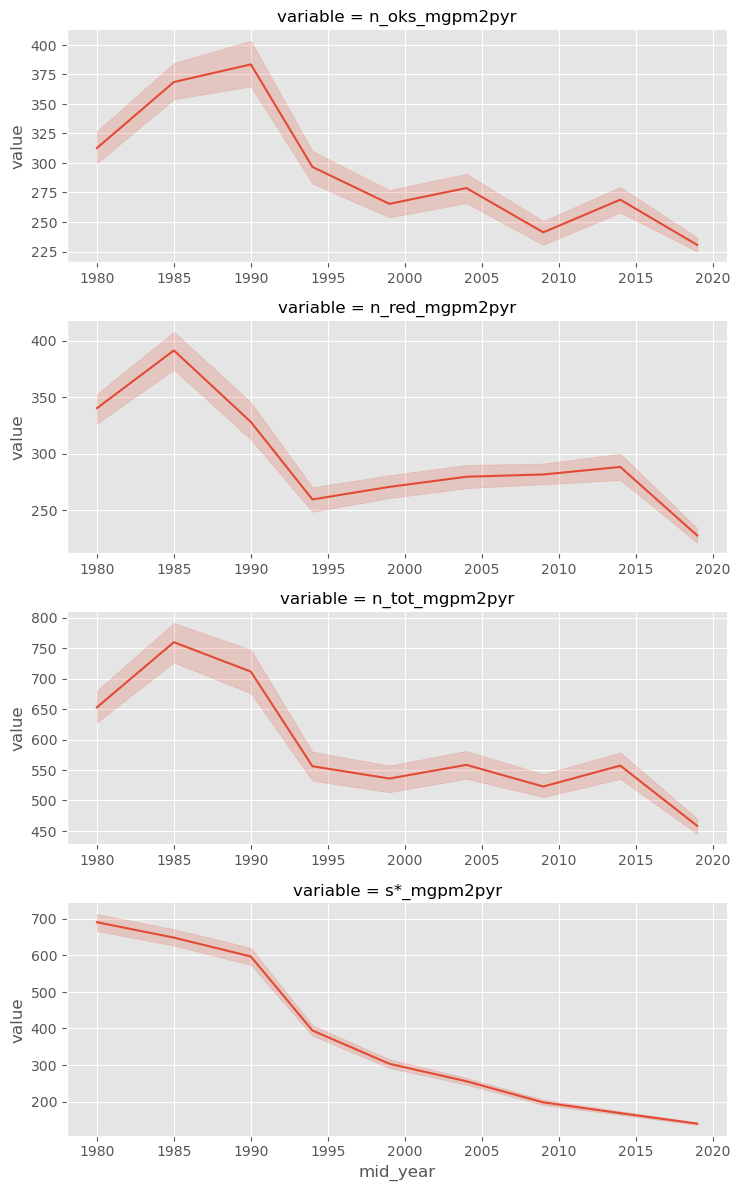

In [6]:
# Plot
df2 = df[
    ["period", "n_oks_mgpm2pyr", "n_red_mgpm2pyr", "n_tot_mgpm2pyr", "s*_mgpm2pyr"]
].melt(id_vars="period")
df2["mid_year"] = (
    df2["period"].str[:4].astype(int) + df2["period"].str[-4:].astype(int)
) / 2
sn.relplot(
    data=df2,
    x="mid_year",
    y="value",
    row="variable",
    kind="line",
    height=3,
    aspect=2.5,
    facet_kws={"sharey": False, "sharex": False},
)

## 3. EMEP deposition scenarios

### 3.1. EMEP historic data for 2017 to 2020

Data for 2021 are not available from the EMEP website, so I'll use the average from 2017-2020 and compare this to 2017-2021 in the NILU data.

In [7]:
def calculate_dep_totals(ds):
    """Takes an xarray netCDF dataset in the format used by EMEP and calculates
    grid average deposition totals:

        Total SOx = Wet SOx + Dry SOx
        Total OxN = Wet OxN + Dry OxN
        Total RedN = Wet RedN + Dry RedN
        Total N = Total OxN + Total RedN

    Args:
        ds: xarray dataset

    Returns:
        New variables are added to 'ds'.
    """
    # Pars of interest
    par_list = [
        "DDEP_SOX_m2Grid",
        "WDEP_SOX",
        "DDEP_OXN_m2Grid",
        "WDEP_OXN",
        "DDEP_RDN_m2Grid",
        "WDEP_RDN",
    ]

    # Check N units are consistent
    for par in par_list:
        unit = ds[par].attrs["units"]
        assert unit in ["mgS/m2", "mgN/m2"], "Units not consistent."

    # Calculate total oxidised S
    ds["DEP_SOX"] = ds["WDEP_SOX"] + ds["DDEP_SOX_m2Grid"]
    ds["DEP_SOX"].attrs["units"] = "mgS/m2"

    # Calculate total oxidised N
    ds["DEP_OXN"] = ds["WDEP_OXN"] + ds["DDEP_OXN_m2Grid"]
    ds["DEP_OXN"].attrs["units"] = "mgN/m2"

    # Calculate total reduced N
    ds["DEP_RDN"] = ds["WDEP_RDN"] + ds["DDEP_RDN_m2Grid"]
    ds["DEP_RDN"].attrs["units"] = "mgN/m2"

    # Calculate total N
    ds["DEP_TOTN"] = (
        ds["WDEP_OXN"] + ds["WDEP_RDN"] + ds["DDEP_OXN_m2Grid"] + ds["DDEP_RDN_m2Grid"]
    )
    ds["DEP_TOTN"].attrs["units"] = "mgN/m2"

    return ds

In [8]:
# List files to process
file_paths = [
    f"https://thredds.met.no/thredds/dodsC/data/EMEP/2022_Reporting/EMEP01_rv4.45_year.{year}met_{year}emis_rep2022.nc"
    for year in range(2017, 2020)
]

# Data for 2020 have a different naming convention/url
file_paths += [
    r"https://thredds.met.no/thredds/dodsC/data/EMEP/2022_Reporting/EMEP01_rv4.45_year.2020met_2020emis.nc"
]

In [9]:
# Open datasets
ds = xr.open_mfdataset(
    file_paths,
    combine="by_coords",
)
ds

<xarray.Dataset>
Dimensions:             (lon: 1200, lat: 520, time: 4)
Coordinates:
  * lon                 (lon) float64 -29.95 -29.85 -29.75 ... 89.75 89.85 89.95
  * lat                 (lat) float64 30.05 30.15 30.25 ... 81.75 81.85 81.95
  * time                (time) datetime64[ns] 2017-07-02T12:00:00 ... 2020-07-02
Data variables: (12/49)
    WDEP_PREC           (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_SOX            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_OXN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_RDN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_MAXO3          (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_PM25water      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    ...                  ...
    SURF_ug_ECFINE      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_ECCOARSE    (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25        (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM_coarse   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM10_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
Attributes:
    vert_coord:                      atmosphere_hybrid_sigma_pressure_coordinate
    Conventions:                     CF-1.6 for coordinates
    model:                           EMEP_MSC-W
    author_of_run:                   emepctm group
    created_date:                    20220923
    created_hour:                    045824.215
    projection:                      lon lat
    period_type:                     fullrun
    run_label:                       rv4_45
    lastmodified_date:               20220924
    lastmodified_hour:               213942.949
    DODS_EXTRA.Unlimited_Dimension:  time

In [10]:
# Load data from URL into memory to improve performance later
ds = ds.load()

In [11]:
# Sum vars in EMEP netCDFs
ds = calculate_dep_totals(ds)

# Get time series for points
par_list = ["DEP_SOX", "DEP_OXN", "DEP_RDN"]
stn_df = stn_gdf.drop("geom", axis="columns")
stn_ds = stn_df.set_index("station_id").to_xarray()
emep_df = (
    ds[par_list]
    .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
    .to_dataframe()
    .reset_index()
)
emep_df["year"] = emep_df["time"].dt.year
emep_df = emep_df[["station_id", "year"] + par_list]
emep_df.rename(
    {
        "DEP_OXN": "n_oks_mgpm2pyr",
        "DEP_RDN": "n_red_mgpm2pyr",
        "DEP_SOX": "s*_mgpm2pyr",
    },
    inplace=True,
    axis="columns",
)

# Average 2017 - 2020
emep_df = emep_df.groupby("station_id").mean().reset_index()

emep_df.head()

,station_id,year,s*_mgpm2pyr,n_oks_mgpm2pyr,n_red_mgpm2pyr
0,259,2018.5,95.956528,299.450806,180.435516
1,260,2018.5,119.037331,364.080872,241.764755
2,261,2018.5,91.153610,266.996155,164.393311
3,262,2018.5,85.894714,268.439514,157.767853
4,263,2018.5,74.210915,215.090729,127.823639


### 3.2. Future scenarios

In [12]:
scenario = "Baseline"  # 'Baseline', 'MFR' or 'Diet_low'

In [13]:
df_list = []
for year in [2030, 2050]:
    fpath = f"/home/jovyan/shared/icp_waters/deposition_data/gp_review_scenarios/EMEP01_rv4.45_met2015_emis{year}_{scenario}_v1C_CCE-ICPwaters.nc"
    ds = xr.open_dataset(fpath)
    ds = calculate_dep_totals(ds)
    scen_df = (
        ds[par_list]
        .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
        .to_dataframe()
        .reset_index()
    )
    scen_df["year"] = str(year)
    scen_df = scen_df[["station_id", "year"] + par_list]
    scen_df.rename(
        {
            "DEP_OXN": "n_oks_mgpm2pyr",
            "DEP_RDN": "n_red_mgpm2pyr",
            "DEP_SOX": "s*_mgpm2pyr",
        },
        inplace=True,
        axis="columns",
    )
    df_list.append(scen_df.set_index(["station_id", "year"]))

scen_df = pd.concat(df_list, axis="rows").reset_index()

# Join EMEP and NILU historic data
scen_df = pd.merge(
    scen_df, emep_df, on="station_id", how="left", suffixes=("_emep_scen", "_emep_base")
)
nilu_df = df.query("period == '2017-2021'")[
    ["station_id", "n_oks_mgpm2pyr", "n_red_mgpm2pyr", "s*_mgpm2pyr"]
]
scen_df = pd.merge(scen_df, nilu_df, on="station_id", how="left")

# Calculate changes relative to NILU baseline
for par in ["n_oks_mgpm2pyr", "n_red_mgpm2pyr", "s*_mgpm2pyr"]:
    scen_df[par] = (
        scen_df[par] * scen_df[par + "_emep_scen"] / scen_df[par + "_emep_base"]
    )
    del scen_df[par + "_emep_scen"], scen_df[par + "_emep_base"]
del scen_df["year_emep_base"]

scen_df["n_tot_mgpm2pyr"] = scen_df["n_oks_mgpm2pyr"] + scen_df["n_red_mgpm2pyr"]

scen_df.rename(
    {
        "year_emep_scen": "period",
    },
    inplace=True,
    axis="columns",
)

scen_df = pd.merge(scen_df, stn_df, on="station_id", how="left")

scen_df.head()

   station_id    year  s*_mgpm2pyr  n_oks_mgpm2pyr  n_red_mgpm2pyr
0         259  2018.5    95.956528      299.450806      180.435516
      station_id  year  s*_mgpm2pyr  n_oks_mgpm2pyr  n_red_mgpm2pyr
0            259  2030    77.770805      178.708405      189.217224
1001         259  2050    71.769135      130.779816      196.103516
   station_id  n_oks_mgpm2pyr  n_red_mgpm2pyr  s*_mgpm2pyr
0         259      242.088297      188.527636   119.524462


,station_id,period,n_oks_mgpm2pyr,n_red_mgpm2pyr,s*_mgpm2pyr,n_tot_mgpm2pyr,station_code,station_name,aquamonitor_id,longitude,latitude
0,259,2030,144.475194,197.703183,96.872135,342.178377,221-1-2,Langtjern,26070,11.850610,59.809915
1,260,2030,152.634438,215.928364,98.813350,368.562802,101-2-7,Hokksjøen,26071,11.559946,59.005125
2,261,2030,133.014606,176.362307,80.705696,309.376913,402-2-13,Sætertjern,26072,12.443670,60.057771
3,262,2030,135.536793,198.752168,85.250224,334.288961,419-1-25,Mjøgsjøen,26073,11.845276,60.332035
4,263,2030,127.410672,165.048447,78.056487,292.459118,425-2-2,Kottern,26074,12.511994,60.587319


In [14]:
# Append scenarios to NILU historic data
df = pd.concat([df, scen_df], axis="rows")

# Save
csv_path = r"../data/1000_lakes_nilu_dep_1978-2021_plus_scenarios.csv"
df.to_csv(csv_path, index=False)

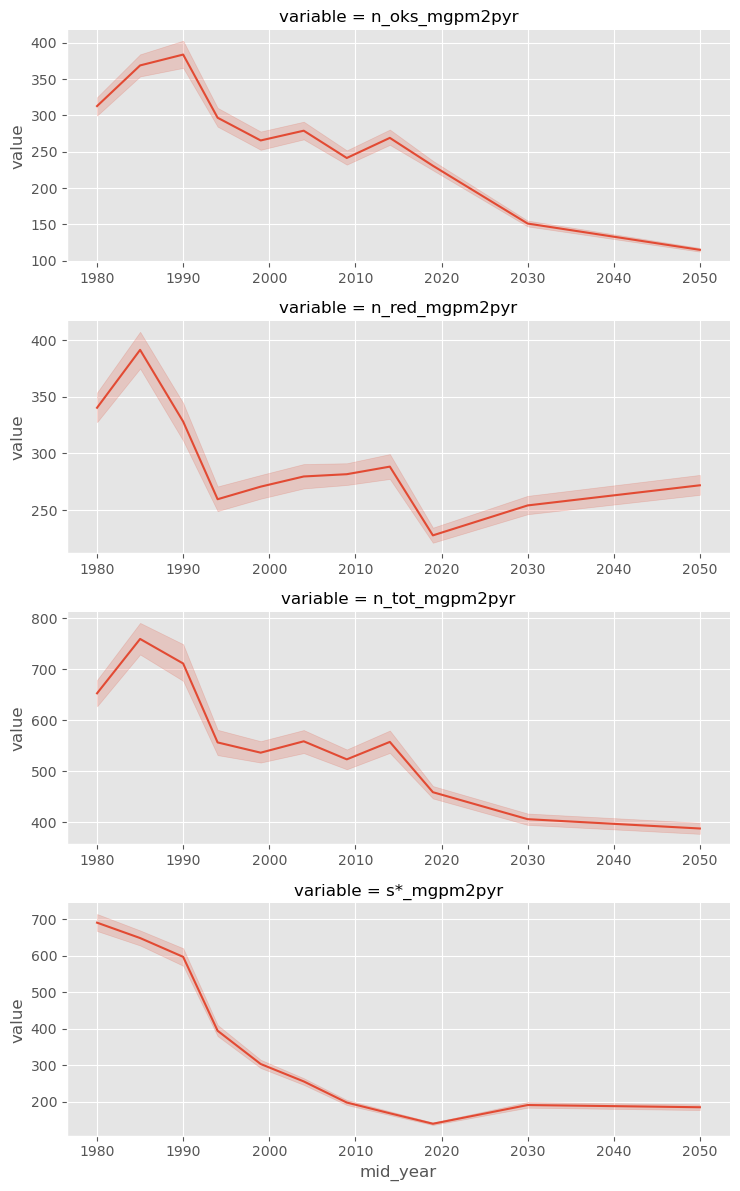

In [15]:
# Plot
df2 = df[
    ["period", "n_oks_mgpm2pyr", "n_red_mgpm2pyr", "n_tot_mgpm2pyr", "s*_mgpm2pyr"]
].melt(id_vars="period")
df2["mid_year"] = (
    df2["period"].str[:4].astype(int) + df2["period"].str[-4:].astype(int)
) / 2
sn.relplot(
    data=df2,
    x="mid_year",
    y="value",
    row="variable",
    kind="line",
    height=3,
    aspect=2.5,
    facet_kws={"sharey": False, "sharex": False},
)